<a href="https://colab.research.google.com/github/itzrnvr/deeplearning-lab/blob/main/assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Deep Q-Learning for CartPole

In [1]:
# Initial Setup: Install and Import Libraries
# Uncomment the following line if running on Colab or a fresh environment
# !pip install gymnasium[box2d,atari,accept-rom-license]

import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

### Hyperparameters and Environment Setup

In [2]:
# Hyperparameters
GAMMA = 0.95  # Discount factor
MEMORY_SIZE = 2000  # Replay buffer capacity
MINIBATCH_SIZE = 32
INITIAL_EPSILON = 1.0
MIN_EPSILON = 0.1  # For the first run
EPSILON_DECAY = 0.995
TARGET_UPDATE_RATE = 10  # Episodes
LEARNING_RATE = 0.001
NUM_EPISODES = 100

# Initialize CartPole environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(f"State size: {state_size}, Action size: {action_size}")

State size: 4, Action size: 2


### Deep Q-Network (DQN) Agent

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate, gamma, initial_epsilon, min_epsilon, epsilon_decay, memory_size, target_update_rate):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=memory_size)
        self.target_update_rate = target_update_rate
        self.q_network = self._build_model()
        self.target_q_network = self._build_model()
        self.update_target_network()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        self.target_q_network.set_weights(self.q_network.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.q_network.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_q_network.predict(next_state, verbose=0)[0])
            target_f = self.q_network.predict(state, verbose=0)
            target_f[0][action] = target
            self.q_network.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.min_epsilon, self.epsilon)

    def load(self, name):
        self.q_network.load_weights(name)

    def save(self, name):
        self.q_network.save_weights(name)

### Training the DQN Agent

In [4]:
agent = DQNAgent(
    state_size=state_size,
    action_size=action_size,
    learning_rate=LEARNING_RATE,
    gamma=GAMMA,
    initial_epsilon=INITIAL_EPSILON,
    min_epsilon=MIN_EPSILON,
    epsilon_decay=EPSILON_DECAY,
    memory_size=MEMORY_SIZE,
    target_update_rate=TARGET_UPDATE_RATE
)

scores = []
epsilon_history = []

for episode in range(1, NUM_EPISODES + 1):
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward_episode = 0
    for t in range(500):  # CartPole-v1 max steps
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward_episode += reward
        if done:
            break
    agent.replay(MINIBATCH_SIZE)
    if episode % agent.target_update_rate == 0:
        agent.update_target_network()
    scores.append(total_reward_episode)
    epsilon_history.append(agent.epsilon)
    print(f"Episode: {episode}, Score: {total_reward_episode}, Epsilon: {agent.epsilon:.3f}")

env.close()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1, Score: 11.0, Epsilon: 1.000
Episode: 2, Score: 37.0, Epsilon: 0.995
Episode: 3, Score: 19.0, Epsilon: 0.990
Episode: 4, Score: 16.0, Epsilon: 0.985
Episode: 5, Score: 8.0, Epsilon: 0.980
Episode: 6, Score: 18.0, Epsilon: 0.975
Episode: 7, Score: 11.0, Epsilon: 0.970
Episode: 8, Score: 28.0, Epsilon: 0.966
Episode: 9, Score: 14.0, Epsilon: 0.961
Episode: 10, Score: 20.0, Epsilon: 0.956
Episode: 11, Score: 20.0, Epsilon: 0.951
Episode: 12, Score: 12.0, Epsilon: 0.946
Episode: 13, Score: 13.0, Epsilon: 0.942
Episode: 14, Score: 11.0, Epsilon: 0.937
Episode: 15, Score: 15.0, Epsilon: 0.932
Episode: 16, Score: 14.0, Epsilon: 0.928
Episode: 17, Score: 20.0, Epsilon: 0.923
Episode: 18, Score: 52.0, Epsilon: 0.918
Episode: 19, Score: 25.0, Epsilon: 0.914
Episode: 20, Score: 36.0, Epsilon: 0.909
Episode: 21, Score: 15.0, Epsilon: 0.905
Episode: 22, Score: 23.0, Epsilon: 0.900
Episode: 23, Score: 13.0, Epsilon: 0.896
Episode: 24, Score: 56.0, Epsilon: 0.891
Episode: 25, Score: 14.0, 

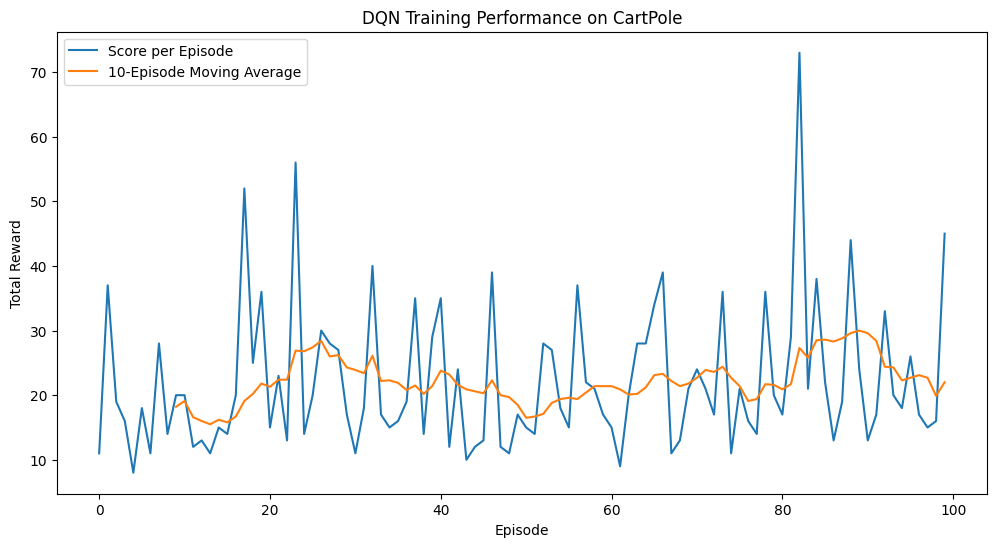

In [5]:
# Plotting Results
plt.figure(figsize=(12, 6))
plt.plot(scores, label='Score per Episode')
window = 10
if len(scores) >= window:
    moving_avg = np.convolve(scores, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(scores)), moving_avg, label=f'{window}-Episode Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance on CartPole')
plt.legend()
plt.show()

### Answering Questions from Assignment PDF

#### 6.1 Epsilon Value During Training

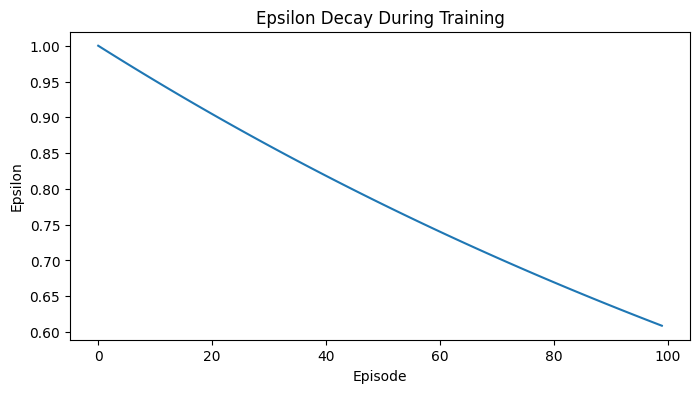

In [6]:
# Plot epsilon vs. episodes
plt.figure(figsize=(8, 4))
plt.plot(epsilon_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay During Training')
plt.show()

*(Answer for Q1 will be based on this plot and understanding of epsilon-greedy exploration.)*

#### 6.2 Episodes for Epsilon to Reach Minimum Value

In [7]:
# Experiment 1: min_epsilon = 0.1
epsilon = 1.0
min_epsilon = 0.1
decay = 0.995
episodes = 0
while epsilon > min_epsilon:
    epsilon *= decay
    episodes += 1
print(f"Episodes for epsilon to reach 0.1: {episodes}")

Episodes for epsilon to reach 0.1: 460


In [8]:
# Experiment 2: min_epsilon = 0.01
epsilon = 1.0
min_epsilon = 0.01
decay = 0.995
episodes = 0
while epsilon > min_epsilon:
    epsilon *= decay
    episodes += 1
print(f"Episodes for epsilon to reach 0.01: {episodes}")

Episodes for epsilon to reach 0.01: 919


*(Results from these code blocks will be used for Q2.)*

#### 6.3 Other Observations (Parameter Variation)

You can try varying parameters such as `LEARNING_RATE` or `GAMMA` and observe the effect on training. For example, try setting `LEARNING_RATE = 0.01` or `GAMMA = 0.99` and run the training for 20-30 episodes to see how the agent's learning speed and stability change.

*(Observations from any variations here can be used for Q3.)*